## EDA

Columns:

`Education` : The educational qualifications of employees, including degree, institution, and field of study.

`Joining Year` : The year each employee joined the company, indicating their length of service.

`City` : The location or city where each employee is based or works.

`Payment Tier` : Categorization of employees into different salary tiers. (數字越小層級越高)

`Age` : The age of each employee, providing demographic insights.

`Gender` : Gender identity of employees, promoting diversity analysis.

`Ever Benched` : Indicates if an employee has ever been temporarily without assigned work.

`Experience in Current Domain` : The number of years of experience employees have in their current field.

`Leave or Not` : a target column 預測是否離職

In [21]:
#Data Handling
import numpy as np 
import pandas as pd 

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#statistics
from scipy import stats

In [22]:
data = pd.read_csv('Employee.csv')
data.head()

Education  JoiningYear       City  PaymentTier  Age  Gender EverBenched  \
0  Bachelors         2017  Bangalore            3   34    Male          No   
1  Bachelors         2013       Pune            1   28  Female          No   
2  Bachelors         2014  New Delhi            3   38  Female          No   
3    Masters         2016  Bangalore            3   27    Male          No   
4    Masters         2017       Pune            3   24    Male         Yes   

   ExperienceInCurrentDomain  LeaveOrNot  
0                          0           0  
1                          3           1  
2                          2           0  
3                          5           1  
4                          2           1

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


In [24]:
data['LeaveOrNot'] = data['LeaveOrNot'].astype(object)
data['PaymentTier'] = data['PaymentTier'].astype(object)

In [25]:
data.shape

(4653, 9)

In [26]:
import os
pic_path = './picture/'

In [27]:
tmp  = list(data.dtypes != np.int64)
cols = data.columns[tmp].tolist()
print(cols)

['Education', 'City', 'PaymentTier', 'Gender', 'EverBenched', 'LeaveOrNot']


In [28]:
tmp  = list(data.dtypes == np.int64)
num_cols = data.columns[tmp].tolist()
print(num_cols)

['JoiningYear', 'Age', 'ExperienceInCurrentDomain']


In [29]:
def plot_hist(name):
    sns.countplot(x = name, data = data)
    plt.ylabel('Total')
    plt.xlabel(name)
    plt.savefig(os.path.join(pic_path, name))
    plt.figure().clear()

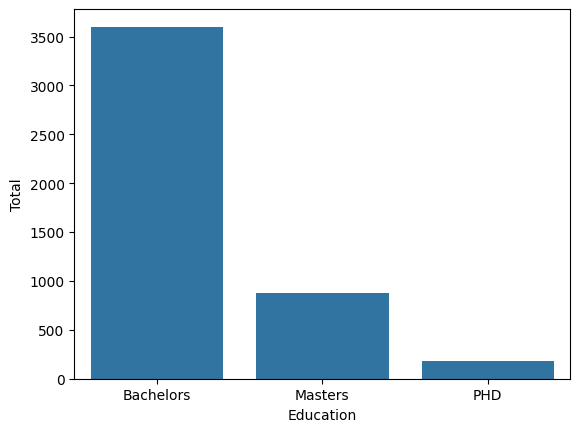

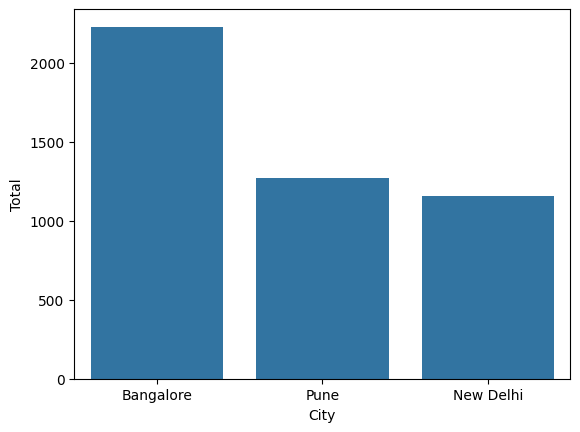

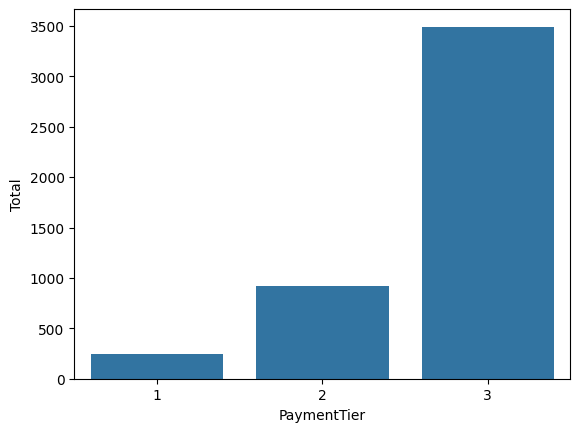

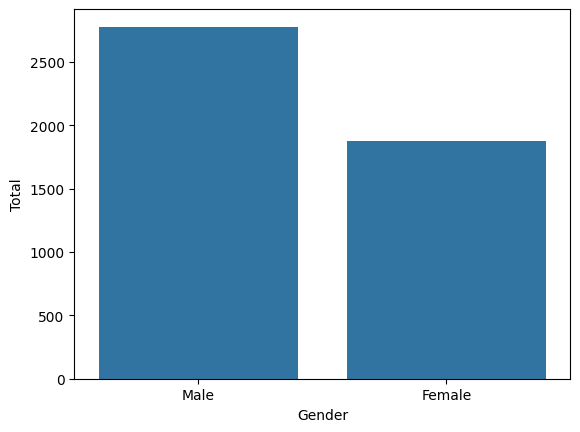

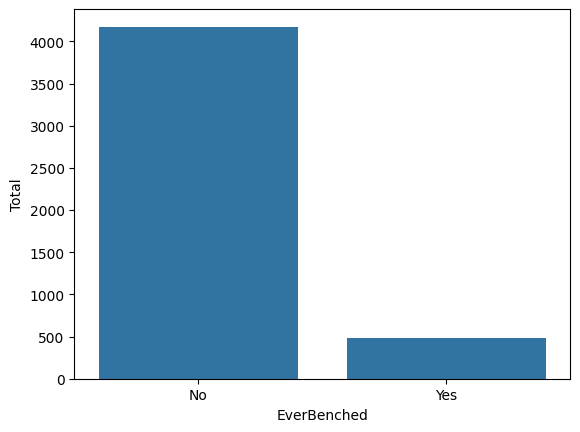

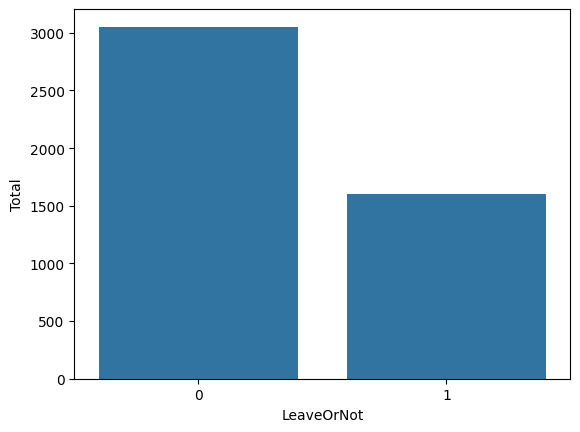

<Figure size 640x480 with 0 Axes>

In [30]:
tmp = list(map(plot_hist, cols))

In [31]:
def plot_box(name):
    sns.boxplot(data = data, x = name)
    plt.xlabel(name)
    plt.savefig(os.path.join(pic_path, name))
    plt.figure().clear()

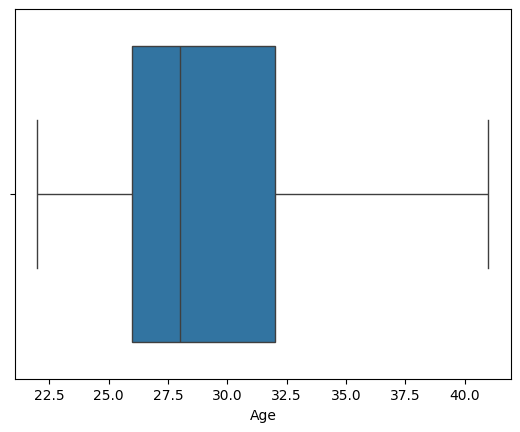

<Figure size 640x480 with 0 Axes>

In [32]:
tmp = list(map(plot_box, num_cols))

In [33]:
cols.remove('LeaveOrNot')
print(cols)

['Education', 'City', 'PaymentTier', 'Gender', 'EverBenched']


In [34]:
def plot_bi_hist(name):
    sns.countplot(x = name, data = data, hue = 'LeaveOrNot')
    plt.ylabel('Total')
    plt.xlabel(name)
    name = "bivariate_" + name
    plt.savefig(os.path.join(pic_path, name))
    plt.figure().clear()

In [35]:
def plot_bi_box(name):
    sns.boxplot(data = data, x = 'LeaveOrNot', y = name)
    name = "bivariate_" + name
    plt.savefig(os.path.join(pic_path, name))
    plt.figure().clear()

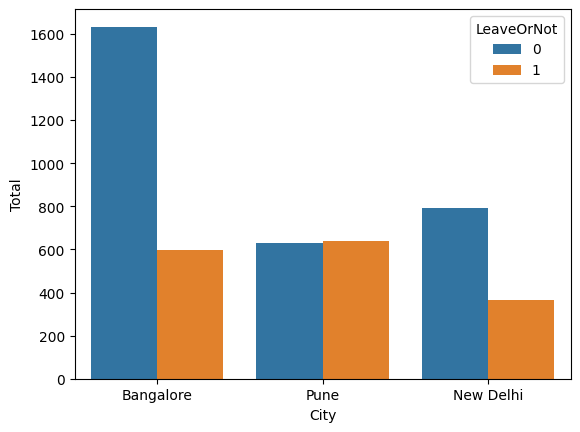

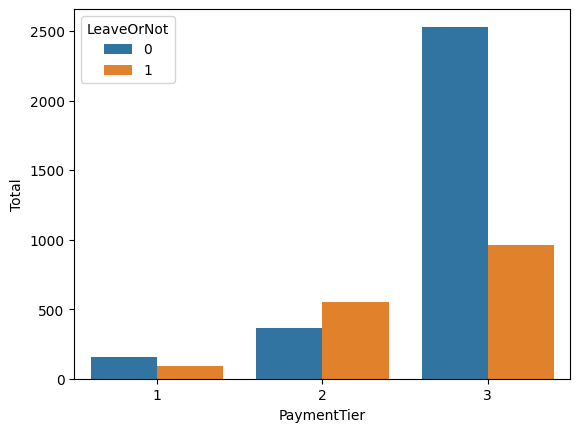

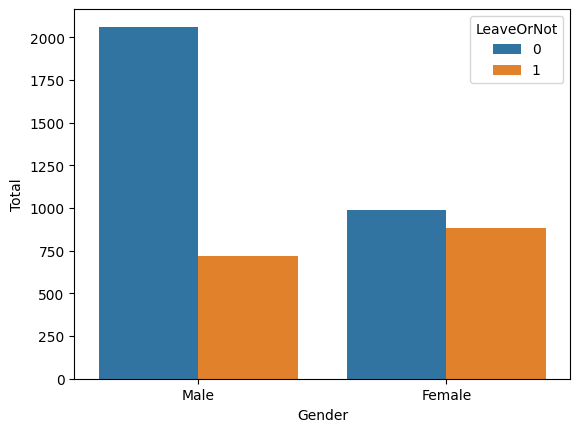

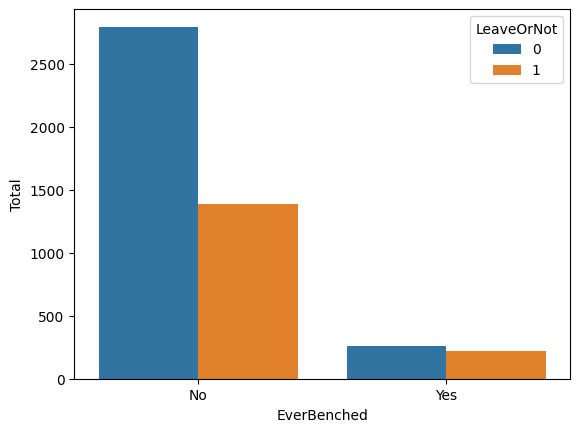

<Figure size 640x480 with 0 Axes>

In [36]:
tmp = list(map(plot_bi_hist, cols))

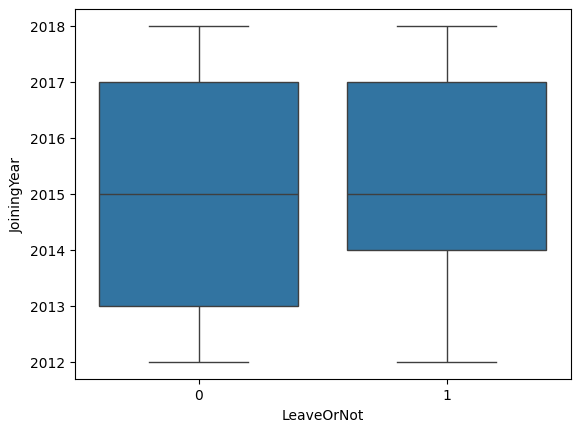

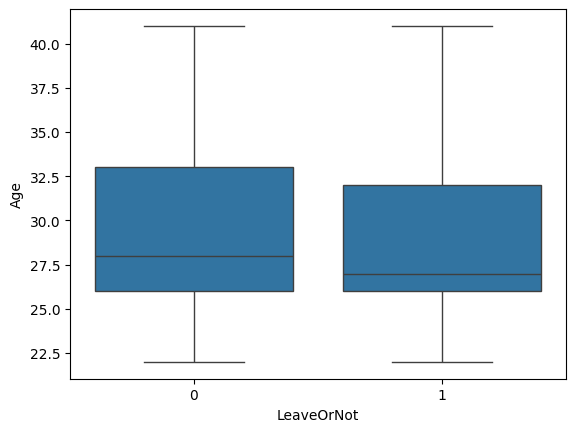

<Figure size 640x480 with 0 Axes>

In [37]:
tmp = list(map(plot_bi_box, num_cols))

In [38]:
def stats_test(col):
  if data[col].dtype == np.int64 or data[col].dtype == np.float64:
    tmp0 = data.loc[data['LeaveOrNot'] == 0, col].values
    tmp1 = data.loc[data['LeaveOrNot'] == 1, col].values

    result = stats.ttest_ind(tmp0, tmp1)[0:2]

  else:
    contingency_table = data.pivot_table(index = [col], columns = 'LeaveOrNot', values = 'Age', aggfunc = 'count')
    contingency_table = contingency_table.fillna(0)
    contingency_table = contingency_table.values

    result = stats.chi2_contingency(contingency_table, correction = False)[0:2]

  return result

In [39]:
all_cols = data.columns[:-1].tolist()
results = {c: stats_test(c) for c in all_cols}
print(results)

{'Education': (101.83014138498626, 7.724417739147332e-23), 'JoiningYear': (-12.601776125876363, 7.90161666436133e-36), 'City': (206.15885400194648, 1.7106992135618012e-45), 'PaymentTier': (338.6305486794045, 2.9329904732261673e-74), 'Age': (3.491261554959713, 0.0004852123420648861), 'Gender': (226.64164837884488, 3.219334068915125e-51), 'EverBenched': (28.627472496502868, 8.772866504669789e-08), 'ExperienceInCurrentDomain': (2.081296101564669, 0.037461383540452)}


全部都顯著，加上feature selection應該要來回對照，所以就先全部餵進去吧

In [40]:
seed = 1126

In [41]:
x = data.drop(['LeaveOrNot'], axis=1)
y = data['LeaveOrNot'].astype(np.int64)

In [42]:
import category_encoders as ce
from sklearn.model_selection import train_test_split

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = seed, stratify = y)

如果你是用lightgbm或catboost的話，他可以直接吃categorical data

用簡單的leave-one-out target encoding encode categorical data

In [44]:
data.head()

Education  JoiningYear       City PaymentTier  Age  Gender EverBenched  \
0  Bachelors         2017  Bangalore           3   34    Male          No   
1  Bachelors         2013       Pune           1   28  Female          No   
2  Bachelors         2014  New Delhi           3   38  Female          No   
3    Masters         2016  Bangalore           3   27    Male          No   
4    Masters         2017       Pune           3   24    Male         Yes   

   ExperienceInCurrentDomain LeaveOrNot  
0                          0          0  
1                          3          1  
2                          2          0  
3                          5          1  
4                          2          1

In [45]:
encoder = ce.LeaveOneOutEncoder(cols = cols, sigma = 0.05)
encoder.fit(x_train, y_train)
x_train = encoder.transform(x_train)
x_test = encoder.transform(x_test)

In [46]:
x_train.head()

Education  JoiningYear      City  PaymentTier  Age    Gender  \
939     0.30982         2017  0.496538     0.271813   27  0.256901   
3326    0.30982         2017  0.496538     0.599185   33  0.476287   
3113    0.30982         2014  0.269016     0.271813   40  0.476287   
69      0.50142         2017  0.269016     0.271813   40  0.476287   
3546    0.50142         2018  0.496538     0.271813   31  0.256901   

      EverBenched  ExperienceInCurrentDomain  
939       0.33094                          5  
3326      0.33094                          2  
3113      0.33094                          0  
69        0.33094                          2  
3546      0.33094                          2

將數值資料standardize

In [47]:
from sklearn.preprocessing import StandardScaler

std_encoder = StandardScaler()
x_train = std_encoder.fit_transform(x_train)
x_test = std_encoder.transform(x_test)

In [48]:
x_train[0:3]

array([[-0.44294974,  1.03450786,  1.59624031, -0.55293904, -0.49837554,
        -0.81065918, -0.33720078,  1.34599141],
       [-0.44294974,  1.03450786,  1.59624031,  1.95811516,  0.74294975,
         1.23356403, -0.33720078, -0.59028018],
       [-0.44294974, -0.57767843, -0.7831341 , -0.55293904,  2.19116258,
         1.23356403, -0.33720078, -1.88112791]])

In [49]:
print(x_train.shape)
print(x_test.shape)

(3722, 8)
(931, 8)


In [50]:
x_train_copy = pd.DataFrame(x_train, columns = data.columns[:-1])
x_train_copy.head()

Education  JoiningYear      City  PaymentTier       Age    Gender  \
0  -0.442950     1.034508  1.596240    -0.552939 -0.498376 -0.810659   
1  -0.442950     1.034508  1.596240     1.958115  0.742950  1.233564   
2  -0.442950    -0.577678 -0.783134    -0.552939  2.191163  1.233564   
3   2.047278     1.034508 -0.783134    -0.552939  2.191163  1.233564   
4   2.047278     1.571903  1.596240    -0.552939  0.329175 -0.810659   

   EverBenched  ExperienceInCurrentDomain  
0    -0.337201                   1.345991  
1    -0.337201                  -0.590280  
2    -0.337201                  -1.881128  
3    -0.337201                  -0.590280  
4    -0.337201                  -0.590280

<Axes: >

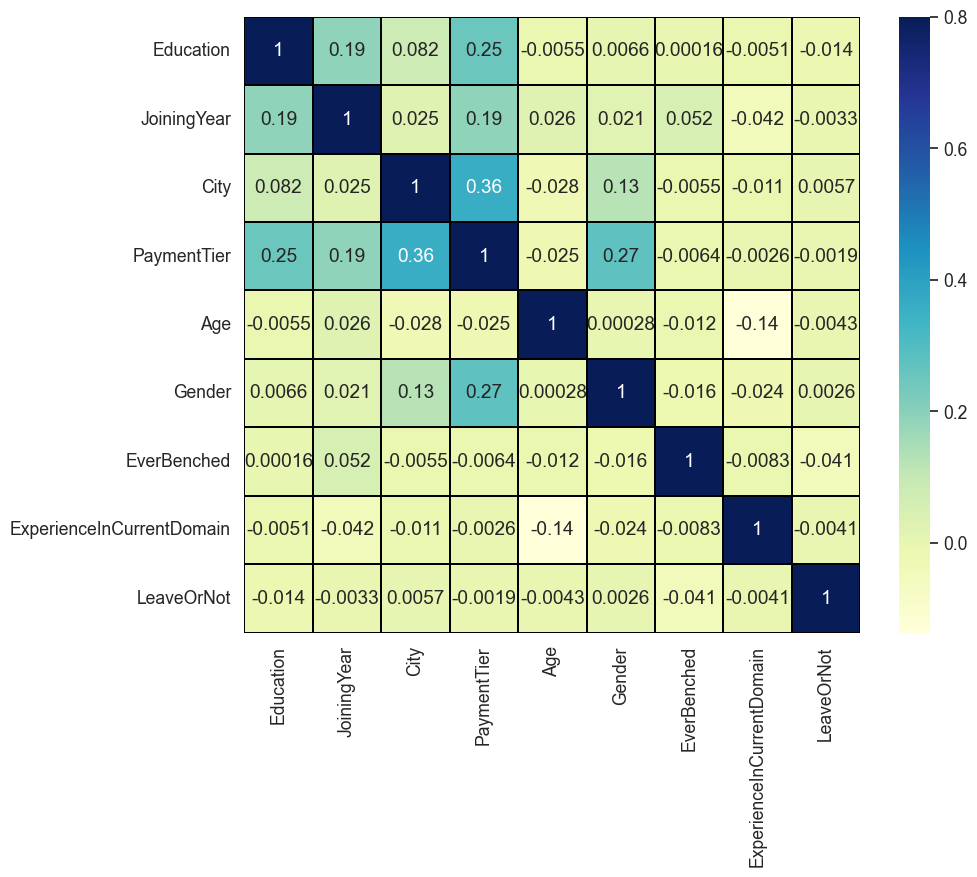

In [51]:
sns.set(font_scale = 1.15)
plt.figure(figsize = (10, 8))
sns.heatmap(pd.concat([x_train_copy, y_train], axis = 1).corr(), vmax = 0.8, linewidths = 0.01, square = True, 
            annot = True, cmap='YlGnBu',
linecolor = 'black')

用border line smote去做upsampling

In [52]:
from imblearn.over_sampling import BorderlineSMOTE

smote_enn = BorderlineSMOTE(random_state = seed)
x_train_resampled, y_train_resampled = smote_enn.fit_resample(x_train, y_train)

直接補到0 1同樣數量

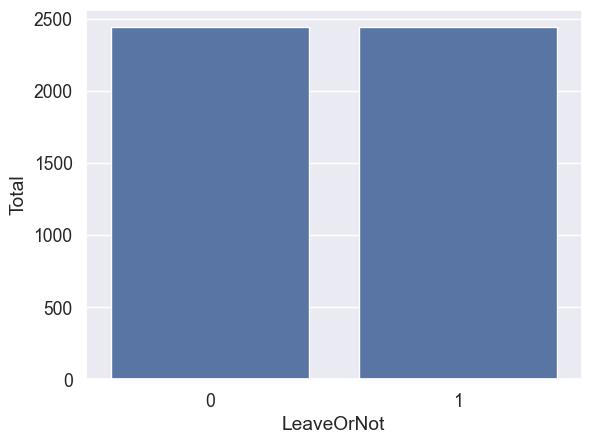

In [53]:
sns.countplot(x = y_train_resampled)
plt.ylabel('Total')
plt.xlabel('LeaveOrNot')
plt.show()

In [54]:
y_train_resampled.shape

(4884,)

## SVM, MLP, GBM

In [55]:
## 定義評估函數
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from pprint import pprint

def eval_pipeline(y_test, y_pred, y_pred_prob):
    report = classification_report(y_test, y_pred, output_dict = True).get('0')
    auc = roc_auc_score(y_test, y_pred_prob)
    report['auc'] = auc
    pprint(report)
    return report

def plot_confusion_matrix(y_test, y_pred, title = None):
    title = 'Confusion Matrix' + title if title else 'Confusion Matrix'
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
def plot_roc_curve(y_test, y_pred, title):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, color = 'darkorange', lw = 2)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    title = 'ROC Curve' + title if title else 'ROC Curve'
    plt.title('ROC Curve')
    plt.show()

### SVM

In [56]:
from sklearn import svm

def svm_model(kernel, x_train, y_train, x_test, y_test,):
    print("Kernel: ", kernel)
    clf_svm = svm.SVC(random_state = seed, kernel=kernel, probability=True)
    clf_svm.fit(x_train, y_train)

    y_pred = clf_svm.predict(x_test)
    y_pred_prob = clf_svm.predict_proba(x_test)[:, 1]
    report = eval_pipeline(y_test, y_pred, y_pred_prob)
    plot_confusion_matrix(y_test, y_pred, kernel)
    return report

Kernel:  linear
{'auc': 0.7055058306055646,
 'f1-score': 0.7144136078782453,
 'precision': 0.7885375494071146,
 'recall': 0.6530278232405892,
 'support': 611.0}


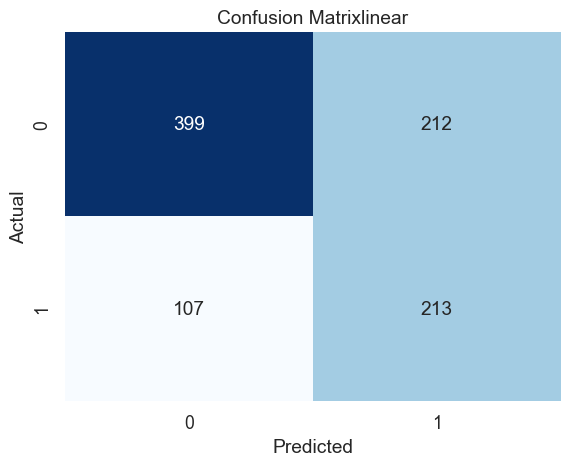

Kernel:  poly
{'auc': 0.8172437602291327,
 'f1-score': 0.8382838283828383,
 'precision': 0.8452579034941764,
 'recall': 0.8314238952536824,
 'support': 611.0}


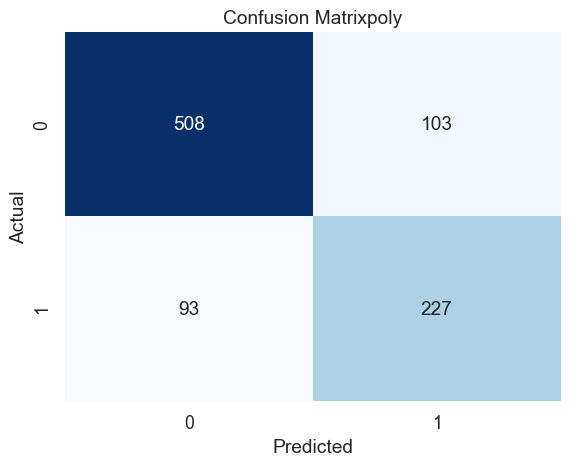

Kernel:  rbf
{'auc': 0.8438829787234042,
 'f1-score': 0.8455696202531645,
 'precision': 0.872822299651568,
 'recall': 0.8199672667757774,
 'support': 611.0}


Kernel:  sigmoid
{'auc': 0.6417195171849428,
 'f1-score': 0.5073800738007379,
 'precision': 0.5813953488372093,
 'recall': 0.4500818330605565,
 'support': 611.0}




BEST ONE:  {'precision': 0.872822299651568, 'recall': 0.8199672667757774, 'f1-score': 0.8455696202531645, 'support': 611.0, 'auc': 0.8438829787234042}


In [57]:
# 根據情況調整參數
# 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
best_svm_repo = None

best_svm_model = None
# SMOTE後的資料
for kernel in kernels:
    if best_svm_repo is None:
        best_svm_repo = svm_model(kernel, x_train_resampled, y_train_resampled, x_test, y_test)
    else:
        cur_svm_repo = svm_model(kernel, x_train_resampled, y_train_resampled, x_test, y_test)
        if cur_svm_repo['auc'] > best_svm_repo['auc']:
            best_svm_repo = cur_svm_repo
print("\n\nBEST ONE: ", best_svm_repo)

使用 Radial Basis Function (RBF) 的效果最佳。

Kernel:  linear
{'auc': 0.6768233428805237,
 'f1-score': 0.7911764705882353,
 'precision': 0.7182910547396528,
 'recall': 0.8805237315875614,
 'support': 611.0}




BEST ONE:  {'precision': 0.872822299651568, 'recall': 0.8199672667757774, 'f1-score': 0.8455696202531645, 'support': 611.0, 'auc': 0.8438829787234042}
Kernel:  poly
{'auc': 0.8219235883797054,
 'f1-score': 0.8847023360964581,
 'precision': 0.8198324022346368,
 'recall': 0.9607201309328969,
 'support': 611.0}




BEST ONE:  {'precision': 0.872822299651568, 'recall': 0.8199672667757774, 'f1-score': 0.8455696202531645, 'support': 611.0, 'auc': 0.8438829787234042}
Kernel:  rbf
{'auc': 0.8455068535188216,
 'f1-score': 0.8927756653992396,
 'precision': 0.8338068181818182,
 'recall': 0.9607201309328969,
 'support': 611.0}




BEST ONE:  {'precision': 0.8338068181818182, 'recall': 0.9607201309328969, 'f1-score': 0.8927756653992396, 'support': 611.0, 'auc': 0.8455068535188216}
Kernel:  sigmoid
{'auc': 0.6128247749590834,
 'f1-score': 0.6232709519934907,
 'precision': 0.6197411003236246,
 'recall': 0.6268412438625205,
 'support': 611.0}


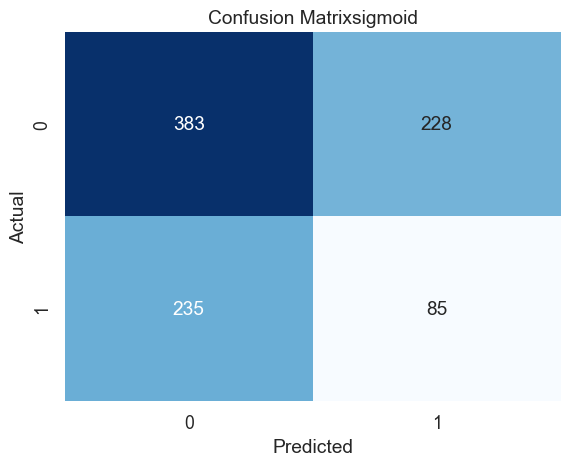



BEST ONE:  {'precision': 0.8338068181818182, 'recall': 0.9607201309328969, 'f1-score': 0.8927756653992396, 'support': 611.0, 'auc': 0.8455068535188216}


In [58]:
for kernel in kernels:
    if best_svm_repo is None:
        best_svm_repo = svm_model(kernel, x_train, y_train, x_test, y_test)
        
    else:
        cur_svm_repo = svm_model(kernel, x_train, y_train, x_test, y_test)
        if cur_svm_repo['auc'] > best_svm_repo['auc']:
            best_svm_repo = cur_svm_repo
    print("\n\nBEST ONE: ", best_svm_repo)

### MLP

In [59]:
from sklearn.neural_network import MLPClassifier

def mlp_model(x_train, y_train, x_test, y_test, max_iter=100):
    clf_mlp = MLPClassifier(random_state = seed, max_iter=max_iter, momentum=0.99, early_stopping=True, learning_rate_init=0.001)
    clf_mlp.fit(x_train, y_train)

    y_pred = clf_mlp.predict(x_test)
    y_pred_prob = clf_mlp.predict_proba(x_test)[:, 1]
    repo = eval_pipeline(y_test, y_pred, y_pred_prob)
    plot_confusion_matrix(y_test, y_pred)
    return repo


In [60]:
# SMOTE
best_mlp_repo = None
for max_iter in range(200, 601, 200):
    if best_mlp_repo is None:
        best_mlp_repo = mlp_model(x_train_resampled, y_train_resampled, x_test, y_test, max_iter)
    else:
        cur_mlp_repo = mlp_model(x_train_resampled, y_train_resampled, x_test, y_test, max_iter)
        if cur_mlp_repo['auc'] > best_mlp_repo['auc']:
            best_mlp_repo = cur_mlp_repo
print("\n\nBEST ONE: ", best_mlp_repo)

{'auc': 0.8277848813420622,
 'f1-score': 0.790820829655781,
 'precision': 0.8582375478927203,
 'recall': 0.7332242225859247,
 'support': 611.0}


{'auc': 0.8277848813420622,
 'f1-score': 0.790820829655781,
 'precision': 0.8582375478927203,
 'recall': 0.7332242225859247,
 'support': 611.0}


{'auc': 0.8277848813420622,
 'f1-score': 0.790820829655781,
 'precision': 0.8582375478927203,
 'recall': 0.7332242225859247,
 'support': 611.0}




BEST ONE:  {'precision': 0.8582375478927203, 'recall': 0.7332242225859247, 'f1-score': 0.790820829655781, 'support': 611.0, 'auc': 0.8277848813420622}


{'auc': 0.8380242430441898,
 'f1-score': 0.8774094063222823,
 'precision': 0.8294460641399417,
 'recall': 0.9312602291325696,
 'support': 611.0}


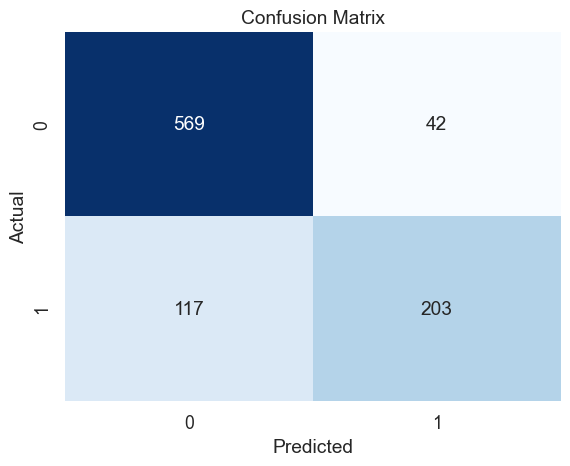

{'auc': 0.8380242430441898,
 'f1-score': 0.8774094063222823,
 'precision': 0.8294460641399417,
 'recall': 0.9312602291325696,
 'support': 611.0}


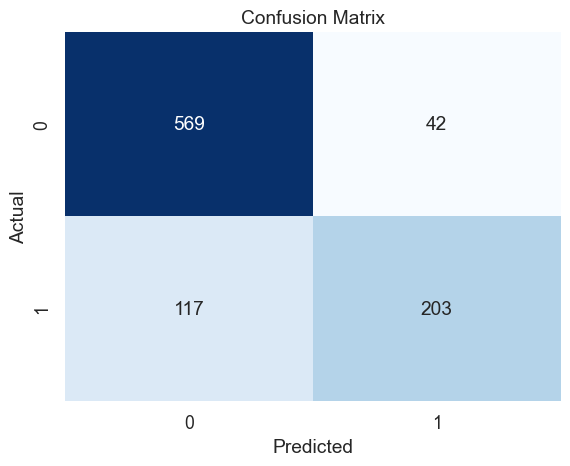

{'auc': 0.8380242430441898,
 'f1-score': 0.8774094063222823,
 'precision': 0.8294460641399417,
 'recall': 0.9312602291325696,
 'support': 611.0}


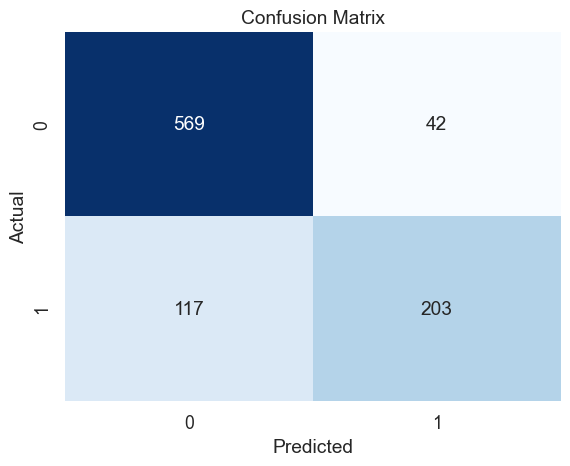



BEST ONE:  {'precision': 0.8294460641399417, 'recall': 0.9312602291325696, 'f1-score': 0.8774094063222823, 'support': 611.0, 'auc': 0.8380242430441898}


In [61]:
# 未使用SMOTE
for max_iter in range(200, 601, 200):
    if best_mlp_repo is None:
        best_mlp_repo = mlp_model(x_train, y_train, x_test, y_test, max_iter)
    else:
        cur_mlp_repo = mlp_model(x_train, y_train, x_test, y_test, max_iter)
        if cur_mlp_repo['auc'] > best_mlp_repo['auc']:
            best_mlp_repo = cur_mlp_repo
print("\n\nBEST ONE: ", best_mlp_repo)

### GBM

In [62]:
# XGBoost
from xgboost import XGBClassifier

def xgb_model(x_train, y_train, x_test, y_test):
    clf_xgb = XGBClassifier(random_state = seed)
    clf_xgb.fit(x_train, y_train)

    y_pred = clf_xgb.predict(x_test)
    y_pred_prob = clf_xgb.predict_proba(x_test)[:, 1]
    report = eval_pipeline(y_test, y_pred, y_pred_prob)
    plot_confusion_matrix(y_test, y_pred)
    return report, clf_xgb
    

In [63]:
best_xgb_repo, clf_xgb = xgb_model(x_train_resampled, y_train_resampled, x_test, y_test)

{'auc': 0.8642721972176759,
 'f1-score': 0.8738019169329074,
 'precision': 0.8533541341653667,
 'recall': 0.8952536824877251,
 'support': 611.0}


In [64]:
model_reports = {
    'svm': best_svm_repo,
    'mlp': best_mlp_repo,
    'xgb': best_xgb_repo
}
pprint(model_reports)

{'mlp': {'auc': 0.8380242430441898,
         'f1-score': 0.8774094063222823,
         'precision': 0.8294460641399417,
         'recall': 0.9312602291325696,
         'support': 611.0},
 'svm': {'auc': 0.8455068535188216,
         'f1-score': 0.8927756653992396,
         'precision': 0.8338068181818182,
         'recall': 0.9607201309328969,
         'support': 611.0},
 'xgb': {'auc': 0.8642721972176759,
         'f1-score': 0.8738019169329074,
         'precision': 0.8533541341653667,
         'recall': 0.8952536824877251,
         'support': 611.0}}


In [65]:
# Create subplots for each metric
fig, axs = plt.subplots(4, figsize=(4,8))

metrics = ['auc', 'f1-score', 'precision', 'recall']

for i, metric in enumerate(metrics):
    values = [model[metric] for model in model_reports.values()]
    max_value = max(values)
    bar_colors = ['green' if value == max_value else 'black' for value in values]
    axs[i].barh(list(model_reports.keys()), values, color=bar_colors)
    axs[i].set_xlabel(metric)
    axs[i].set_xlim([0.75, 1])  # Adjust this as needed

plt.tight_layout()
plt.show()

## Logistic Regression, Decision Tree, Knn

In [66]:
from sklearn.model_selection import GridSearchCV

In [67]:
def Grid_Search(clf, param_grid, x_train, y_train):
    # 使用GridSearchCV進行交叉驗證
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    grid_search.fit(x_train, y_train)

    # 獲取結果
    print(grid_search.best_params_)

### Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression

clf_logistic = LogisticRegression(random_state = seed)

def call_model(clf, x_train, y_train, x_test, y_test):
    # clf = LogisticRegression(random_state = seed)
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    y_pred_prob = clf.predict_proba(x_test)[:, 1]
    eval_pipeline(y_test, y_pred, y_pred_prob)
    plot_confusion_matrix(y_test, y_pred)

{'auc': 0.7083188420621931,
 'f1-score': 0.7339285714285714,
 'precision': 0.8074656188605108,
 'recall': 0.6726677577741408,
 'support': 611.0}


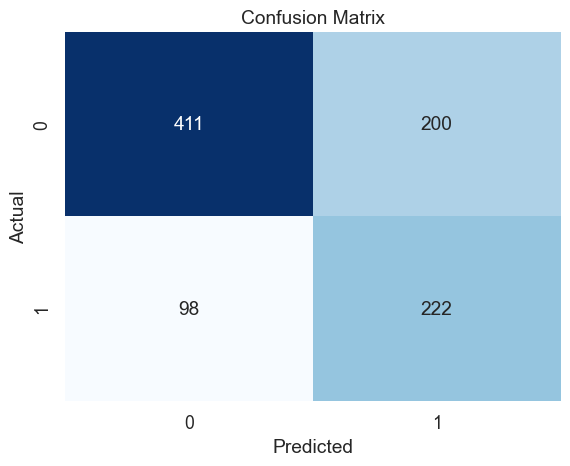

In [69]:
# SMOTE
call_model(clf_logistic, x_train_resampled, y_train_resampled, x_test, y_test)

In [70]:
# Non-SMOTE
call_model(clf_logistic, x_train, y_train, x_test, y_test)

{'auc': 0.7213456423895255,
 'f1-score': 0.7907669396872672,
 'precision': 0.7254098360655737,
 'recall': 0.8690671031096563,
 'support': 611.0}


In [71]:
features = data.columns[:-1]
coefficients = clf_logistic.coef_

for feature, coef in zip(features, coefficients[0]):
    print(f"{feature}: {coef}")

Education: 0.2088362313628319
JoiningYear: 0.33427597899053574
City: 0.28306948388982284
PaymentTier: 0.26958892281867675
Age: -0.13195628609437904
Gender: 0.4022361121790199
EverBenched: 0.17794964516624612
ExperienceInCurrentDomain: -0.05637859757233785


### Decision Tree

In [72]:
from sklearn.tree import DecisionTreeClassifier 

clf_dtree = DecisionTreeClassifier(random_state = seed)

{'auc': 0.7839632774140753,
 'f1-score': 0.8451612903225807,
 'precision': 0.8330683624801272,
 'recall': 0.8576104746317512,
 'support': 611.0}


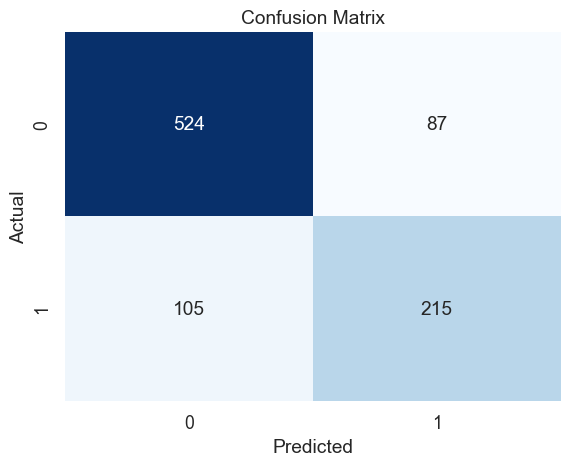

In [73]:
# SMOTE
call_model(clf_dtree, x_train_resampled, y_train_resampled, x_test, y_test)

In [74]:
# Non-SMOTE
call_model(clf_dtree, x_train, y_train, x_test, y_test)

{'auc': 0.7910929828150574,
 'f1-score': 0.8528,
 'precision': 0.8341158059467919,
 'recall': 0.8723404255319149,
 'support': 611.0}


In [75]:
param_grid = {'max_depth': range(1, 11), 'min_samples_split': range(2, 11), 'min_samples_leaf': range(1, 6), 'max_features': range(2, 9)}

Grid_Search(clf_dtree, param_grid, x_train, y_train)

{'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [76]:
clf_dtree = DecisionTreeClassifier(random_state = seed, max_depth = 8, max_features = 8, min_samples_leaf = 5, min_samples_split = 2)

call_model(clf_dtree, x_train, y_train, x_test, y_test)

{'auc': 0.8630856178396071,
 'f1-score': 0.8861154446177847,
 'precision': 0.8464977645305514,
 'recall': 0.9296235679214403,
 'support': 611.0}


In [77]:
# 獲取特徵重要性
feature_importance = clf_dtree.feature_importances_

# 將特徵名稱與其重要性配對並排序
feature_importance_dict = dict(zip(data.columns[:-1], feature_importance))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# 顯示特徵重要性
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

JoiningYear: 0.3694371835151089
PaymentTier: 0.22506393415639547
City: 0.13528287772401948
Education: 0.10534043518528949
Age: 0.06287472741321691
Gender: 0.050535517564261785
ExperienceInCurrentDomain: 0.0359472863913551
EverBenched: 0.015518038050352904


### Knn

In [78]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(n_neighbors=9)

{'auc': 0.8304572422258591,
 'f1-score': 0.8079584775086506,
 'precision': 0.8568807339449541,
 'recall': 0.7643207855973814,
 'support': 611.0}


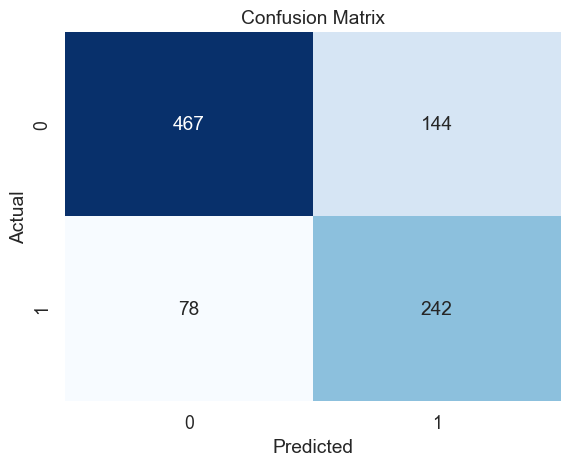

In [79]:
# SMOTE
call_model(clf_knn, x_train_resampled, y_train_resampled, x_test, y_test)

{'auc': 0.8339172463175123,
 'f1-score': 0.8704980842911878,
 'precision': 0.8184438040345822,
 'recall': 0.9296235679214403,
 'support': 611.0}


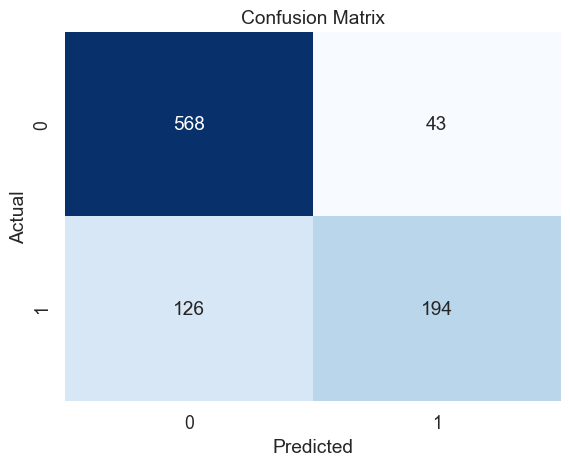

In [80]:
# Non-SMOTE
call_model(clf_knn, x_train, y_train, x_test, y_test)

In [81]:
# 設置參數網格
param_grid = {'n_neighbors': range(1, 11)}

# 使用GridSearchCV進行交叉驗證
grid_search = GridSearchCV(clf_knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(x_train, y_train)

# 獲取最佳的 n_neighbors 值
best_n_neighbors = grid_search.best_params_['n_neighbors']
print(f"Best n_neighbors: {best_n_neighbors}")

Best n_neighbors: 9


{'auc': 0.8339172463175123,
 'f1-score': 0.8704980842911878,
 'precision': 0.8184438040345822,
 'recall': 0.9296235679214403,
 'support': 611.0}


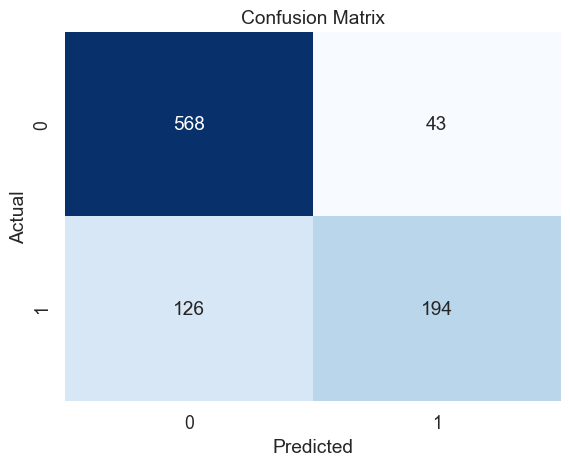

In [82]:
clf_knn = KNeighborsClassifier(n_neighbors=9)

# Non-SMOTE
call_model(clf_knn, x_train, y_train, x_test, y_test)

### 不確定這樣做對不對

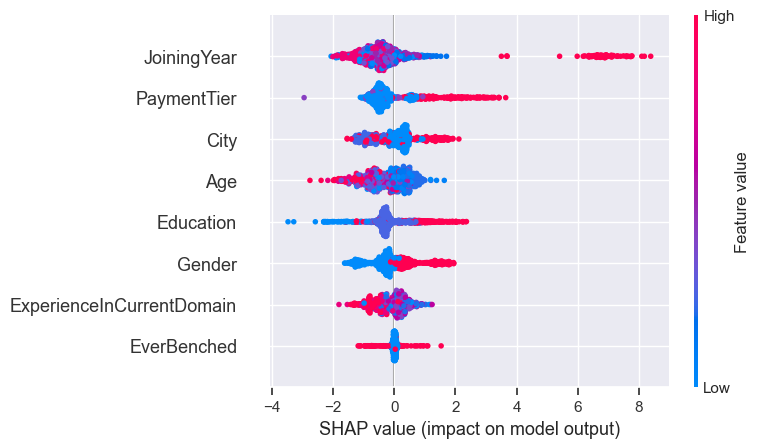

In [83]:
import shap

x_train_copy = pd.DataFrame(x_train, columns = data.columns[:-1])
x_test_copy = pd.DataFrame(x_test, columns = data.columns[:-1])

shap.initjs()

# 創建 SHAP 解釋器
explainer = shap.TreeExplainer(clf_xgb)
# 計算 SHAP 值
shap_values = explainer(x_test_copy)

shap.summary_plot(shap_values, x_test_copy)

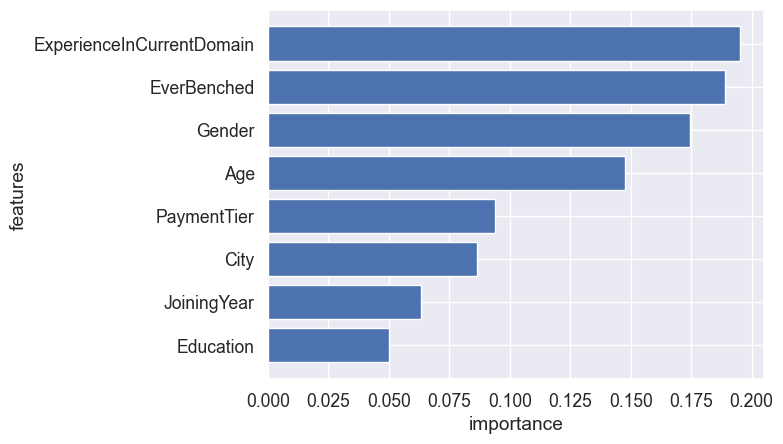

In [96]:
def plot_feature_importances(model):
      n_features = x.shape[1]
      sort_idx = model.feature_importances_.argsort()
      plt.barh(x_train_copy.columns[sort_idx],model.feature_importances_[sort_idx], align="center")
      plt.yticks(np.arange(n_features),x)
      plt.xlabel("importance")
      plt.ylabel("features")
      plt.show
plot_feature_importances(clf_xgb)